In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/fruits_dataset.zip -d /content/data

In [4]:
!pip install -qqq tensorflow

## CNN based model (VGG16)

Imports

In [35]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

Model preparation

In [36]:
# Define input image size
IMAGE_SIZE = [224, 224]

# Load VGG16 CNN without the top layers
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze all pretrained layers
for layer in vgg.layers:
  layer.trainable = False

# Add custom layers for our classification task

# Flatten iutput from the CNN from a multidimentional tensor to 1D layer to fit in the dense layer
x = Flatten()(vgg.output)

# This layer performs the classification. (PD across 15 classes)
prediction = Dense(15, activation='softmax', dtype='float32')(x)

# Define the model, specify input and output layers
model = Model(inputs=vgg.input, outputs=prediction)

# Display model architecture
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │         376,335 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,091,023 (57.57 MB)

 Trainable params: 376,335 (1.44 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [37]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

Data augmentation

In [38]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
train_generator = train_datagen.flow_from_directory(
    '/content/data/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

test_generator = test_datagen.flow_from_directory(
    '/content/data/Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 14356 images belonging to 15 classes.
Found 2458 images belonging to 15 classes.


In [40]:
def preprocess_img(image, label):
    return image, label

# Function to generate data from ImageDataGenerator
def train_data_gen():
    for batch in train_generator:
        yield batch[0], batch[1]

def test_data_gen():
    for batch in test_generator:
        yield batch[0], batch[1]

# Convert ImageDataGenerator datasets to `tf.data.Dataset`
train_ds = tf.data.Dataset.from_generator(
    train_data_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 15), dtype=tf.float32),
    )
).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_generator(
    test_data_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 15), dtype=tf.float32),
    )
).prefetch(tf.data.AUTOTUNE)



In [41]:
train_ds = train_ds.cache()
test_ds = test_ds.cache()

In [42]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())
print("GPU Name:", tf.test.gpu_device_name())

GPU Available: True
GPU Name: /device:GPU:0


Train the model

In [43]:
import os

train_dir = "/content/data/Train"
class_counts = {}
for class_folder in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_folder] = num_images
        print(f"Class '{class_folder}' has {num_images} images.")

Class 'AppleOverripe' has 839 images.
Class 'AppleRipe' has 1072 images.
Class 'AppleUnripe' has 1213 images.
Class 'BananaOverripe' has 1436 images.
Class 'BananaRipe' has 1217 images.
Class 'BananaUnripe' has 1200 images.
Class 'OrangeOverripe' has 807 images.
Class 'OrangeRipe' has 413 images.
Class 'OrangeUnderripe' has 600 images.
Class 'RaspberryOverripe' has 760 images.
Class 'RaspberryRipe' has 930 images.
Class 'RaspberryUnderripe' has 997 images.
Class 'StrawberryOverripe' has 915 images.
Class 'StrawberryRipe' has 952 images.
Class 'StrawberryUnderripe' has 1020 images.


In [44]:
import numpy as np

# Suppose 'class_indices' is your dictionary: { 'AppleOverripe':0, ..., 'StrawberryUnderripe':14 }
class_indices = train_generator.class_indices  # or the same structure you printed earlier
inv_class_indices = {v: k for k, v in class_indices.items()}  # invert to {0:'AppleOverripe', ...}

# 1. Gather the counts in class order
counts_in_index_order = [class_counts[inv_class_indices[i]] for i in range(len(class_indices))]

# 2. Compute weights: e.g., weight_i = total_images / (number_of_classes * count_i)
total = sum(counts_in_index_order)
num_classes = len(counts_in_index_order)
class_weights = {}
for i, count in enumerate(counts_in_index_order):
    class_weights[i] = total / (num_classes * count)

print("Class Weights:", class_weights)


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Class Weights: {0: 1.1419149781485896, 1: 0.8937189054726368, 2: 0.7898323715306402, 3: 0.6671773444753946, 4: 0.787236373596275, 5: 0.7983888888888889, 6: 1.187195373812474, 7: 2.319774011299435, 8: 1.5967777777777779, 9: 1.2606140350877193, 10: 1.030179211469534, 11: 0.9609495152123035, 12: 1.0470673952641165, 13: 1.0063725490196078, 14: 0.939281045751634}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 105s 229ms/step - accuracy: 0.6623 - loss: 1.2300 - val_accuracy: 0.8483 - val_loss: 0.5076
Epoch 2/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 102s 226ms/step - accuracy: 0.9272 - loss: 0.3003 - val_accuracy: 0.8869 - val_loss: 0.3719
Epoch 3/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 102s 227ms/step - accuracy: 0.9639 - loss: 0.1794 - val_accuracy: 0.9060 - val_loss: 0.3051
Epoch 4/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 102s 227ms/step - accuracy: 0.9768 - loss: 0.1290 - val_accuracy: 0.9260 - val_loss: 0.2573
Epoch 5/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 102s 227ms/step - accuracy: 0.9841 - loss: 0.1004 - val_accuracy: 0.9170 - val_loss: 0.2646
Epoch 6/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 229ms/step - accuracy: 0.9888 - loss: 0.0773 - val_accuracy: 0.9292 - val_loss: 0.2308
Epoch 7/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 230ms/step - accuracy: 0.9923 - loss: 0.0634 - val_accuracy: 0.9227 - val_loss: 0.2335
Epoch 8/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 106s 235ms/step - accuracy: 0.9942 -

Save the model

In [48]:
model.save('fruit_classifier.h5')

Plot accuracy

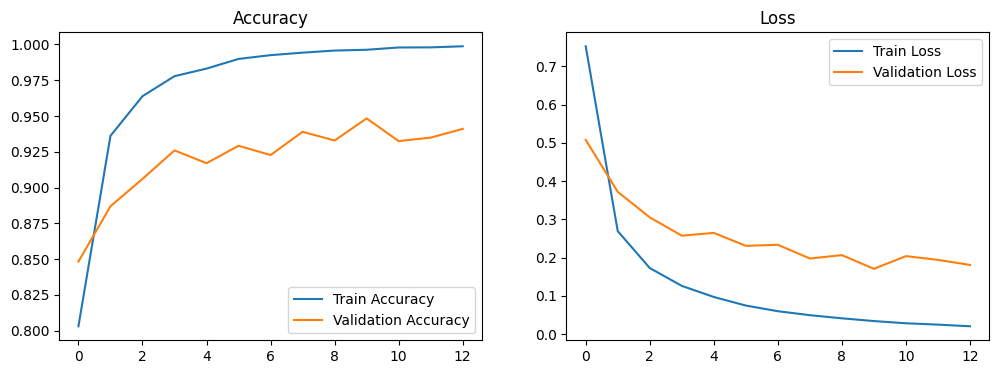

In [46]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()